In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# you can choose one of the following package for image reading/processing
import cv2
import PIL

## 1.1

In [3]:
# Load data
data_dir = './MNIST/'
train_x = np.ones([1, 28*28+1])
test_x = np.ones([1, 28*28+1])

for cls in os.listdir(data_dir):
    img_data = np.ones([1, 28*28+1])
    for filename in os.listdir(os.path.join(data_dir,cls)):
        img = cv2.imread(os.path.join(data_dir, cls, filename), cv2.IMREAD_GRAYSCALE) # 28 * 28
        if img is not None:
            img = img.reshape(1, 28*28)
            img = img / 255 # normalize
            img = np.concatenate((np.array([1]), img), axis=None)
            img_data = np.vstack((img_data, img))  
    img_data = img_data[1:,:]
    np.random.shuffle(img_data)
    test_x = np.vstack((test_x, img_data[:32,:]))
    train_x = np.vstack((train_x, img_data[32:,:]))
test_x = test_x[1:,:]
train_x = train_x[1:,:]

In [4]:
# Build one-hot vector
class_number = 10
oh_vector = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
test_y = np.zeros([1, 10])
train_y = np.zeros([1, 10])
for i in range(class_number):
    for j in range(32):
        tmp_vector = np.roll(oh_vector, i)
        test_y = np.vstack((test_y, tmp_vector))
    for j in range(96):
        tmp_vector = np.roll(oh_vector, i)
        train_y = np.vstack((train_y, tmp_vector))
test_y = test_y[1:]
train_y = train_y[1:]
print(train_y.shape)

(960, 10)


In [5]:
# Least-squares
W_matrix = np.linalg.pinv(train_x) @ train_y
y_pred = test_x @ W_matrix
y_pred = np.argmax(y_pred, axis=1)
test_y_arg = np.argmax(test_y, axis=1)

In [6]:
def RMSE(predictions, targets):
    return np.sqrt(np.square((predictions - targets)).mean())

In [7]:
loss = RMSE(y_pred, test_y_arg)
accuarcy = np.sum(np.equal(y_pred, test_y_arg)/ 320)
print("loss : ", loss)
print("Accuarcy : ", accuarcy)

loss :  3.097882341213107
Accuarcy :  0.503125


## 1.2(a)(b)

In [8]:
data_dir = './MNIST/'
train_x = np.ones([1, 28*28+1])
test_x = np.ones([1, 28*28+1])

for cls in os.listdir(data_dir):
    img_data = np.ones([1, 28*28+1])
    for filename in os.listdir(os.path.join(data_dir,cls)):
        img = cv2.imread(os.path.join(data_dir, cls, filename), cv2.IMREAD_GRAYSCALE) # 28 * 28
        if img is not None:
            img = img.reshape(1, 28*28)
            img = img / 255 # normalize
            img = np.concatenate((np.array([1]), img), axis=None)
            img_data = np.vstack((img_data, img))  
    img_data = img_data[1:,:]
    np.random.shuffle(img_data)
    test_x = np.vstack((test_x, img_data[:32,:]))
    train_x = np.vstack((train_x, img_data[32:,:]))
test_x = test_x[1:,:]
train_x = train_x[1:,:]

In [9]:
# Build one-hot vector
class_number = 10
oh_vector = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
test_y = np.zeros([1, 10])
train_y = np.zeros([1, 10])
for i in range(class_number):
    for j in range(32):
        tmp_vector = np.roll(oh_vector, i)
        test_y = np.vstack((test_y, tmp_vector))
    for j in range(96):
        tmp_vector = np.roll(oh_vector, i)
        train_y = np.vstack((train_y, tmp_vector))
test_y = test_y[1:]
train_y = train_y[1:]


In [10]:
def Softmax(array): #e^x/sum(e^x)
    array = array - np.max(array, axis=1, keepdims=True) # avoid overflow
    Output=np.exp(array)
    recipSum=np.reciprocal( np.sum(Output, axis=1, keepdims=True) )
    Output=np.multiply(Output,recipSum)
    return Output

In [11]:
def Accuracy(y_pred, y_true):
    y_true = np.argmax(y_true, axis=1) if len(y_true.shape)==2 else y_true
    y_pred = np.argmax(y_pred, axis=1) if len(y_pred.shape)==2 else y_pred
    return np.mean(y_true == y_pred)*100

In [12]:
def Crossentropy_loss(y_pred, y_true):
    """
    clip data to prevent divide zero,
    and both side clip in order to keep mean not change.
    """
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7) 
    return np.sum(-(y_true * np.log(y_pred_clipped))) / len(y_pred)

In [13]:
class Gradient:
    def __init__(self, learning_rate=0.001) -> None:
        self.lr = learning_rate
    
    def update(self, model, train_x, train_y):
        y_pred = Softmax((train_x @ model.W) + model.b)
        dw = (1/model.n) * (train_x.T @ (y_pred - train_y))
        db = (1/model.n) * np.sum(y_pred - train_y)
        
        model.W -= self.lr * dw
        model.b -= self.lr * db

In [14]:
class LogisticRegression:
    def __init__(self, *, optimizer) -> None:
        self.W = None
        self.b = None
        self.optimizer = optimizer
    def fit(self, model, train_x, train_y, test_x, test_y, batch_size=1, epochs=100, show=None, shuffle=False):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y

        self.n, self.k = train_x.shape  # n: sample size, k:features number
        self.class_num = 10
        self.batch_size = batch_size
        self.epochs = epochs
        self.max_iter = int(np.ceil(self.n / self.batch_size))
        self.W = np.zeros((self.k, self.class_num))
        self.b = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_loss_list = []
        self.test_acc_list = []
        

        #shuffle
        if shuffle:
            idx = np.arange(self.n)
            np.random.shuffle(idx)
            train_x = train_x[idx].copy()
            train_y = train_y[idx].copy()


        train_x = self.get_batch(train_x)
        train_y = self.get_batch(train_y)

        for epoch in range(epochs):
            for x, y in zip(train_x, train_y):
                self.optimizer.update(model, x, y)

            #train
            y_pred = Softmax((self.train_x @ self.W) + self.b)
            train_loss = Crossentropy_loss(y_pred, self.train_y)
            train_acc = Accuracy(y_pred, self.train_y)
            self.train_loss_list.append(train_loss)
            self.train_acc_list.append(train_acc)
            
            #test
            y_pred = Softmax((self.test_x @ self.W) + self.b)
            test_loss = Crossentropy_loss(y_pred, self.test_y)
            test_acc = Accuracy(y_pred, self.test_y)
            self.test_loss_list.append(test_loss)
            self.test_acc_list.append(test_acc)
            if show is not None:
                if (epoch+1) % show == 0:
                    print(f'|epoch: {epoch+1}| training loss {train_loss:.3f}, trianing acc {train_acc:.3f}, | testing loss {test_loss:.3f} testing acc {test_acc:.3f}')


    def get_batch(self, input):
        return [input[self.batch_size*idx:self.batch_size*(idx+1)] for idx in range(self.max_iter)]

In [15]:
def show_plot(method, method_name):
   plt.figure(figsize=(12,5))
   plt.subplot(121)
   plt.title(method_name)
   plt.xlabel('epoch')
   plt.ylabel('loss')
   plt.plot(range(method.epochs), method.train_loss_list, c='b', label='train')
   plt.plot(range(method.epochs), method.test_loss_list, c='r', label='test')
   plt.legend(loc=0)
   plt.grid(True)
   plt.subplot(122)
   plt.title(method_name)
   plt.xlabel('epoch')
   plt.ylabel('Accuracy(%)')
   plt.plot(range(method.epochs), method.train_acc_list, c='b', label='train')
   plt.plot(range(method.epochs), method.test_acc_list, c='r', label='test')
   plt.legend(loc=0)
   plt.grid(True)
   plt.show()

|epoch: 10| training loss 1.865, trianing acc 77.500, | testing loss 1.861 testing acc 79.062
|epoch: 20| training loss 1.558, trianing acc 80.938, | testing loss 1.552 testing acc 80.938
|epoch: 30| training loss 1.339, trianing acc 82.917, | testing loss 1.333 testing acc 82.812
|epoch: 40| training loss 1.181, trianing acc 83.750, | testing loss 1.176 testing acc 84.062
|epoch: 50| training loss 1.064, trianing acc 84.271, | testing loss 1.061 testing acc 84.375
|epoch: 60| training loss 0.974, trianing acc 85.312, | testing loss 0.973 testing acc 85.000
|epoch: 70| training loss 0.903, trianing acc 85.729, | testing loss 0.905 testing acc 85.000
|epoch: 80| training loss 0.845, trianing acc 85.938, | testing loss 0.850 testing acc 85.625
|epoch: 90| training loss 0.798, trianing acc 86.667, | testing loss 0.806 testing acc 85.938
|epoch: 100| training loss 0.758, trianing acc 87.083, | testing loss 0.769 testing acc 86.875


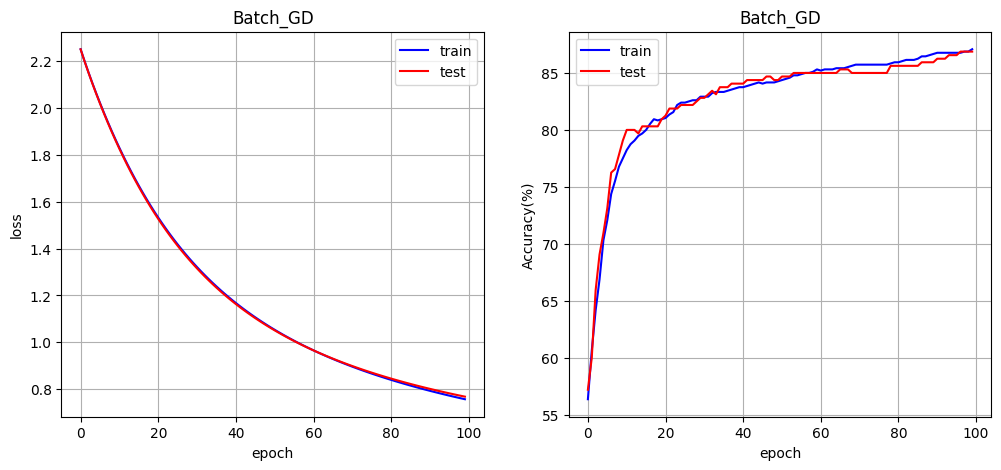

Final training accuracy: 87.08333333333333, training loss: 0.7576665816487597
Final testing accuracy: 86.875, testing loss: 0.7686823245057419


In [16]:
# Batch GD
optimizer = Gradient(learning_rate=0.05)
Batch_GD = LogisticRegression(optimizer=optimizer)
Batch_GD.fit(Batch_GD, train_x, train_y, test_x, test_y, batch_size=len(train_x), epochs=100, show=10, shuffle=True)
show_plot(Batch_GD, 'Batch_GD')
print(f'Final training accuracy: {Batch_GD.train_acc_list[-1]}, training loss: {Batch_GD.train_loss_list[-1]}')
print(f'Final testing accuracy: {Batch_GD.test_acc_list[-1]}, testing loss: {Batch_GD.test_loss_list[-1]}')

|epoch: 10| training loss 1.868, trianing acc 78.125, | testing loss 1.864 testing acc 79.062
|epoch: 20| training loss 1.561, trianing acc 81.250, | testing loss 1.556 testing acc 81.875
|epoch: 30| training loss 1.343, trianing acc 83.021, | testing loss 1.337 testing acc 83.750
|epoch: 40| training loss 1.185, trianing acc 83.854, | testing loss 1.180 testing acc 84.375
|epoch: 50| training loss 1.067, trianing acc 84.583, | testing loss 1.065 testing acc 85.000
|epoch: 60| training loss 0.977, trianing acc 85.208, | testing loss 0.977 testing acc 85.312
|epoch: 70| training loss 0.905, trianing acc 85.729, | testing loss 0.908 testing acc 85.000
|epoch: 80| training loss 0.848, trianing acc 86.042, | testing loss 0.853 testing acc 85.938
|epoch: 90| training loss 0.800, trianing acc 86.667, | testing loss 0.808 testing acc 86.250
|epoch: 100| training loss 0.759, trianing acc 86.875, | testing loss 0.771 testing acc 86.875


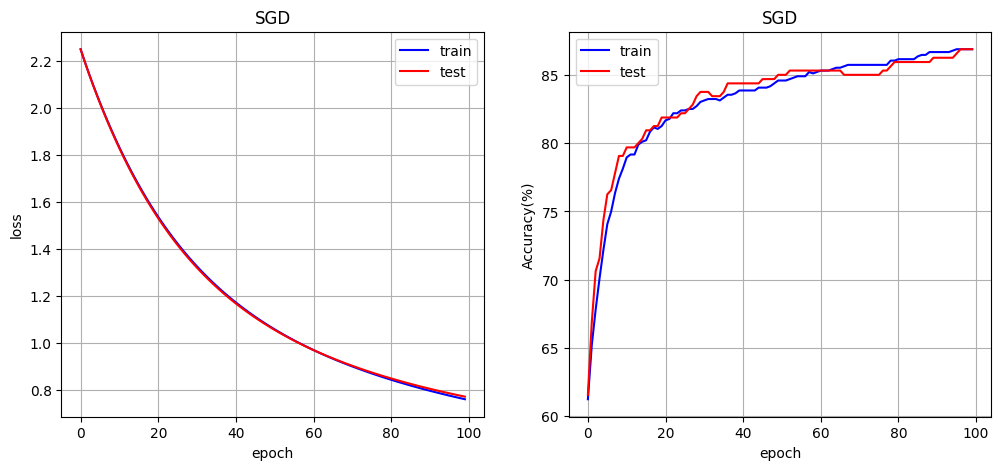

Final training accuracy: 86.875, training loss: 0.7594946170481501
Final testing accuracy: 86.875, training loss: 0.7705353395902731


In [17]:
# SGD
optimizer = Gradient(learning_rate=0.05)
SGD = LogisticRegression(optimizer=optimizer)
SGD.fit(SGD, train_x, train_y, test_x, test_y, batch_size=1, epochs=100, show=10, shuffle=True)
show_plot(SGD, 'SGD')
print(f'Final training accuracy: {SGD.train_acc_list[-1]}, training loss: {SGD.train_loss_list[-1]}')
print(f'Final testing accuracy: {SGD.test_acc_list[-1]}, training loss: {SGD.test_loss_list[-1]}')

|epoch: 10| training loss 1.868, trianing acc 78.333, | testing loss 1.864 testing acc 79.688
|epoch: 20| training loss 1.561, trianing acc 81.354, | testing loss 1.555 testing acc 81.875
|epoch: 30| training loss 1.343, trianing acc 82.917, | testing loss 1.337 testing acc 83.438
|epoch: 40| training loss 1.185, trianing acc 83.646, | testing loss 1.180 testing acc 84.062
|epoch: 50| training loss 1.067, trianing acc 84.479, | testing loss 1.064 testing acc 85.000
|epoch: 60| training loss 0.977, trianing acc 85.208, | testing loss 0.976 testing acc 85.312
|epoch: 70| training loss 0.905, trianing acc 85.729, | testing loss 0.908 testing acc 85.312
|epoch: 80| training loss 0.847, trianing acc 86.250, | testing loss 0.853 testing acc 85.938
|epoch: 90| training loss 0.800, trianing acc 86.354, | testing loss 0.808 testing acc 86.250
|epoch: 100| training loss 0.759, trianing acc 86.875, | testing loss 0.770 testing acc 86.875


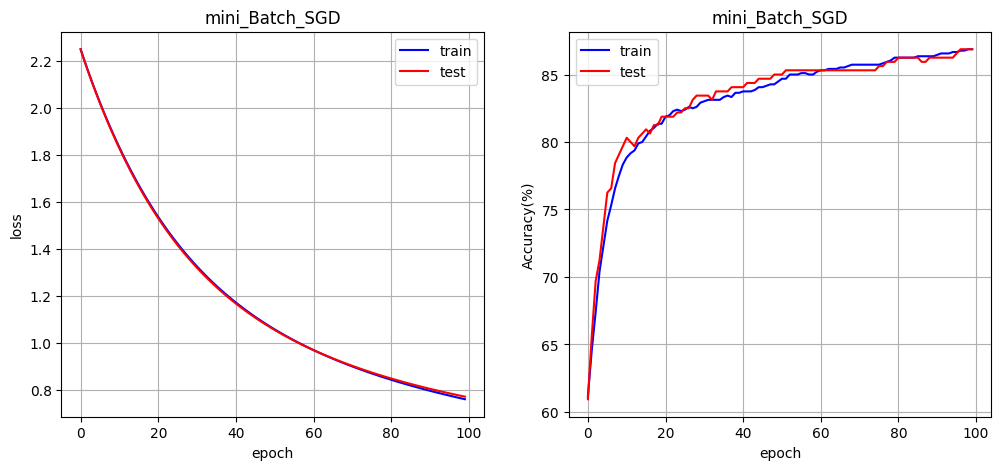

Final training accuracy: 86.875, training loss: 0.7593981851203834
Final testing accuracy: 86.875, testing loss: 0.7703817697898481


In [18]:
# mini-Batch SGD
optimizer = Gradient(learning_rate=0.05)
miniBSGD = LogisticRegression(optimizer=optimizer)
miniBSGD.fit(miniBSGD, train_x, train_y, test_x, test_y, batch_size=32, epochs=100, show=10, shuffle=True)
show_plot(miniBSGD, 'mini_Batch_SGD')
print(f'Final training accuracy: {miniBSGD.train_acc_list[-1]}, training loss: {miniBSGD.train_loss_list[-1]}')
print(f'Final testing accuracy: {miniBSGD.test_acc_list[-1]}, testing loss: {miniBSGD.test_loss_list[-1]}')

## 1.2(c)
* We can found that the implement time of SGD is apparently slower than the other two, however, the resault are pretty much the same.
* Also, SGD's convergence time is earlyer than the other two.

## 1.3
* We can found that the resault of logistic regression is better than least-square's. Although we can use only one-step to predict the answer, but updating the parameter by gradient descent, we can find a more suitable parameter to predict the answer.  

## 2.1

In [19]:
data_x_df = pd.read_csv('x.csv', header=None)
data_t_df = pd.read_csv('t.csv', header=None)

train_x = data_x_df.to_numpy()[:150]
test_x = data_x_df.to_numpy()[150:]
train_y = data_t_df.to_numpy()[:150]
test_y = data_t_df.to_numpy()[150:]

In [20]:
#Generate the Phi matrix for M=1
Phi_matrix_train_M1 = np.concatenate([np.ones([1, len(train_x)]).T, train_x], axis=1)
Phi_matrix_test_M1 = np.concatenate([np.ones([1, len(test_x)]).T, test_x], axis=1)

In [21]:
# Generate the Phi matrix for M=2
D = 1 
def M2_Phi_Matrix(dataset:np.array, D:int):
    tmp_matrix = np.zeros((len(dataset), D*D))
    for row in range(len(dataset)):
        count=0
        for i in range(dataset.shape[1]):
            for j in range(dataset.shape[1]):
                tmp_matrix[row,count] = dataset[row,i] * dataset[row,j]
                count = count + 1
    return tmp_matrix

tmp_matrix_train = M2_Phi_Matrix(train_x, D)
tmp_matrix_test = M2_Phi_Matrix(test_x, D)
Phi_matrix_train_M2 = np.concatenate([Phi_matrix_train_M1, tmp_matrix_train], axis=1)
Phi_matrix_test_M2 = np.concatenate([Phi_matrix_test_M1, tmp_matrix_test], axis=1)

In [22]:
PolynomialKernel = np.dot(Phi_matrix_train_M2, Phi_matrix_train_M2.T)

In [99]:
class Kernel:
    def __init__(self, thetas, mode):
        if mode == 'array':
            self.thetas = np.asarray(thetas).reshape(4,1)
        else:
            self.thetas = thetas

    def distance(self, x):
        assert (type(x) == np.ndarray)
        distance = x.reshape(1, len(x))
        distance = x[0] - distance
        for i in range(len(x)-1):
            temp = x.reshape(1, len(x))
            temp = x[i+1] - temp
            distance = np.concatenate((distance, temp), axis=0)
        return distance

    def multimat(self, x):
        assert (type(x) == np.ndarray)
        mul = x.reshape(1, len(x))
        mul = x[0] * mul
        for i in range(len(x)-1):
            temp = x.reshape(1, len(x))
            temp = x[i+1] * temp
            mul = np.concatenate((mul, temp), axis=0)
        return mul

    def function_1(self, xn, xm):
        return xn.T @ xm

    def function_2(self, xn, xm):
        if ((type(xn) != (np.float64)) and (type(xm) != (np.float64))):  # vector input
            assert (type(xn) == np.ndarray)
            return self.thetas[0] * np.exp(-0.5 * self.thetas[1] * (self.distance(xn) ** 2)) + self.thetas[2] + self.thetas[3] * self.multimat(xn)
        else:  # scalar input
            return self.thetas[0] * np.exp(-0.5 * self.thetas[1] * ((xn - xm) ** 2)) + self.thetas[2] + self.thetas[3] * xn * xm


class GaussianProcessRegression:
    def __init__(self, thetas):
        self.kernel = Kernel(thetas, None)
        self.thetas = thetas
        self.beta_inv = 1

    def Phi(self, x):
        phi = np.array([1, x, x**2], dtype=object)
        return phi

    def fit(self, train_x, train_t, quetion):
        self.train_x = train_x
        self.train_t = train_t
        if quetion == 1:
            self.C_inv = np.linalg.inv(np.dot(
                Phi_matrix_train_M2, Phi_matrix_train_M2.T) + self.beta_inv * np.eye(150))
        elif quetion == 2:
            self.C_inv = np.linalg.inv(self.kernel.function_2(
                self.train_x, self.train_x) + self.beta_inv * np.eye(150))

    def predict(self,data, quetion):
        data_size = len(data)
        m = np.empty(data_size)
        std = np.empty(data_size)
        if quetion == 1:
            for i in range(data_size):
                k = self.kernel.function_1(
                    self.Phi(self.train_x), self.Phi(data[i]))
                m[i] = k.T @ self.C_inv @ self.train_t
                c = self.kernel.function_1(
                    self.Phi(data[i]), self.Phi(data[i])) + self.beta_inv
                std[i] = np.sqrt(c - (k.T @ self.C_inv @ k))

        elif quetion == 2:
            for i in range(data_size):
                k = self.kernel.function_2(self.train_x, data[i])
                m[i] = k.T @ self.C_inv @ self.train_t
                c = self.kernel.function_2(data[i], data[i]) + self.beta_inv
                std[i] = np.sqrt(c - (k.T @ self.C_inv @ k))

        return m, std

    def RMSE(self, data, test_x, test_t, Q):
        data_size = len(data)
        train_m = np.empty(data_size)
        test_m = np.empty(data_size)
        if Q == 1:
            # calculate training mean
            for i in range(data_size): 
                k = self.kernel.function_1(self.Phi(self.train_x), self.Phi(data[i]))
                train_m[i] = k.T @ self.C_inv @ self.train_t
            
            #calculate testing mean
            for i in range(data_size):  
                k = self.kernel.function_1(self.Phi(self.train_x), self.Phi(data[i]))
                test_m[i] = k.T @ self.C_inv @ test_t 

            train_RMSE = np.sqrt(np.mean(np.square(train_m - self.train_t)))
            test_RMSE = np.sqrt(np.mean(np.square(test_m - test_t)))

        elif Q == 2:
            # calculate training mean
            for i in range(data_size):
                k = self.kernel.function_2(self.train_x, data[i])
                train_m[i] = k.T @ self.C_inv @ self.train_t

            # calculate testing mean
            for i in range(data_size):
                k = self.kernel.function_2(self.train_x, data[i])
                test_m[i] = k.T @ self.C_inv @ test_t
            
            
            train_RMSE = np.sqrt(np.mean(np.square(train_m - self.train_t)))
            test_RMSE = np.sqrt(np.mean(np.square(test_m - test_t)))

        return train_RMSE, test_RMSE

    def show(self, data, m, std, pos=None):
        if pos != None:
            plt.subplot(221+pos)
        if self.thetas != None:
            plt.title('\u03B8 = ' + str(self.thetas))
        plt.plot(data, m, 'r-')
        plt.fill_between(data, m + std, m - std, color='pink', alpha=0.5)
        plt.scatter(self.train_x, self.train_t,
                    facecolors='none', edgecolors='b')

    def ARD(self, train_x, lr):
        self.train_x = train_x

        def grad(self, term):
            dc = np.zeros((len(self.train_x), len(self.train_x)))
            for n in range(len(self.train_x)):
                for m in range(len(self.train_x)):
                    if term == 0:  # theta0
                        dc[n][m] = np.exp(-0.5*self.thetas[1] *
                                          (self.train_x[n] - self.train_x[m])**2)
                    elif term == 1:  # theta1
                        dc[n][n] = self.thetas[0] * np.exp(-0.5*self.thetas[1]*(
                            (self.train_x[n]-self.train_x[m])**2)) * (-0.5**((self.train_x[n]-self.train_x[m])**2))
                    elif term == 2:  # theta2
                        dc[n][m] = 1
                    else:  # theta3
                        dc[n][m] = np.dot(self.train_x[n].T, self.train_x[m])
            return dc
        epoch = 0
        ex = []
        tmp_array = np.zeros((4,1))
        for i in range(len(self.thetas)):
            tmp_array[i] = self.thetas[i] 
        while epoch < 10:
            ex += [epoch]
            update = np.zeros((4, 1))
            flag = 0
            for term in range(4):
                update[term] = -0.5 * np.trace((self.C_inv @ grad(self, term))) + 0.5 * (
                    self.train_t.T @ self.C_inv @ grad(self, term) @ self.C_inv @ self.train_t)
                if np.absolute(update[term]) < 6:
                    flag += 1
            tmp_array += lr * update  # update thetas
            self.kernel = Kernel(tmp_array, 'array')  # update kernel
            self.C_inv = np.linalg.inv(self.kernel.function_2(
                self.train_x, self.train_x) + self.beta_inv * np.eye(150))
            epoch += 1
            print(f'|epoch {epoch} |: \u03B8 = {tmp_array.flatten()}')
            if flag == 4:
                # break
                pass
        self.thetas = tmp_array.tolist()


train_RMSE: 4.6676941474214555, test_RMSE: 4.362559470982356


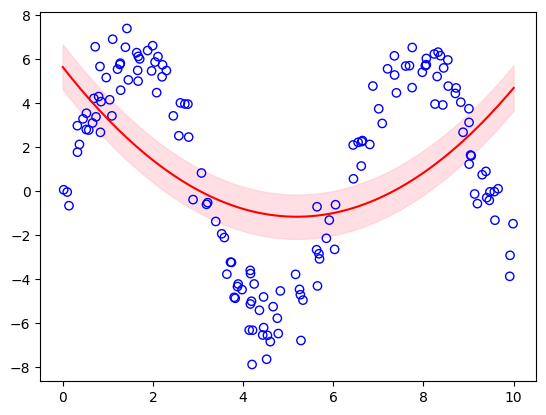

In [54]:
GPR = GaussianProcessRegression(thetas=None)
Quetion = 1
GPR.fit(train_x, train_y, Quetion)
data = np.linspace(0, 10, 150)
m, std = GPR.predict(data, Quetion)
GPR.show(data, m, std)
train_RMSE, test_RMSE = GPR.RMSE(data, test_x, test_y, 1)
print(f'train_RMSE: {train_RMSE}, test_RMSE: {test_RMSE}')

## 2.2 Exponential Quadratic Kernel Function

In [55]:
thetas_list = [[0,0,0,1], [1,1,0,0], [1,1,0,16], [1,2,16,0]]

θ= [0, 0, 0, 1] train_RMSE: 4.291952417367137, test_RMSE: 4.378160628953406
θ= [1, 1, 0, 0] train_RMSE: 5.69261886559084, test_RMSE: 4.660767898494823
θ= [1, 1, 0, 16] train_RMSE: 5.691546673865336, test_RMSE: 4.659783119020172
θ= [1, 2, 16, 0] train_RMSE: 5.682303578924327, test_RMSE: 4.698323778103935


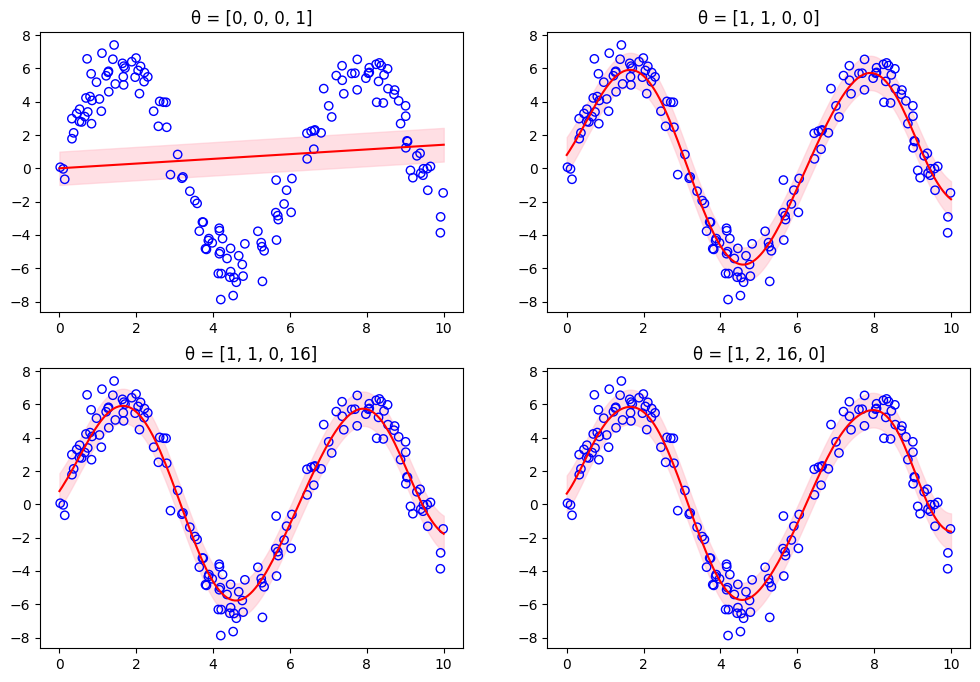

In [73]:
plt.figure(figsize= (12, 8))
for i in range(4):
    GPR = GaussianProcessRegression(thetas=thetas_list[i])
    Quetion = 2
    GPR.fit(train_x, train_y, Quetion)
    data = np.linspace(0, 10, 150)
    m, std = GPR.predict(data, Quetion)
    train_RMSE, test_RMSE = GPR.RMSE(data, test_x, test_y, 2)
    GPR.show(data, m, std, i)
    print(f'\u03B8= {thetas_list[i]} train_RMSE: {train_RMSE}, test_RMSE: {test_RMSE}')
   

## 2.3 Automatic Relevance determination

|epoch 1 |: θ = [ 8.00116153  7.04016359  7.99963045 86.99994257]
|epoch 2 |: θ = [ 8.00241354  7.08012244  7.99926082 86.99988514]
|epoch 3 |: θ = [ 8.00375476  7.11987872  7.99889111 86.99982771]
|epoch 4 |: θ = [ 8.00518397  7.15943457  7.99852131 86.99977028]
|epoch 5 |: θ = [ 8.00669997  7.19879214  7.99815143 86.99971285]
|epoch 6 |: θ = [ 8.00830159  7.23795354  7.99778147 86.99965543]
|epoch 7 |: θ = [ 8.00998766  7.27692087  7.99741143 86.999598  ]
|epoch 8 |: θ = [ 8.01175705  7.3156962   7.99704131 86.99954057]
|epoch 9 |: θ = [ 8.01360867  7.35428161  7.99667111 86.99948314]
|epoch 10 |: θ = [ 8.01554142  7.39267913  7.99630083 86.99942571]
train_RMSE: 5.7846065039406795, test_RMSE: 5.08319168973357


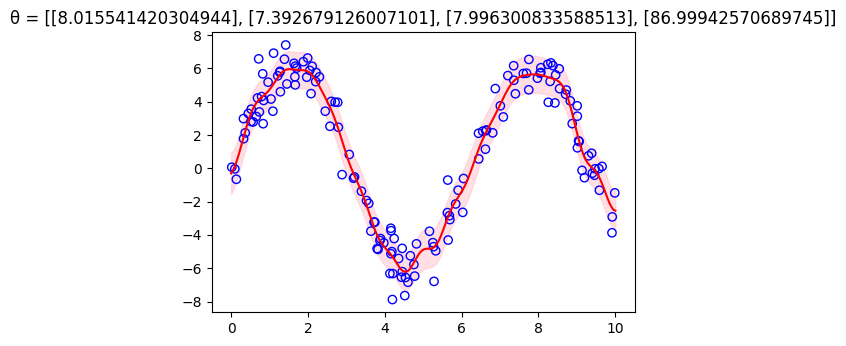

In [100]:
#ARD

GPR = GaussianProcessRegression(thetas=[8.,7.,8.,87.])
Quetion = 2
GPR.fit(train_x, train_y, Quetion)
GPR.ARD(train_x, 0.01)
data = np.linspace(0, 10, 300)
m, std = GPR.predict(data, Quetion)
plt.figure(figsize=(12,8))
train_RMSE, test_RMSE = GPR.RMSE(data, test_x, test_y, 2)
GPR.show(data, m, std, 0)
print(f'train_RMSE: {train_RMSE}, test_RMSE: {test_RMSE}')

## 2.4
* As the resault above, the standard polynomial kernel can't correctlly predict the mean, however, if we use exponential-quadratic kernel function instead, we can fine-tine the hyperparameter theta to estimate a better kernel to predict. Furthermore, we can use Automatic Relevance Determination to fine-tune.
* Compare with different $\theta$, I think that the ${\theta}_0$ is the most attribute parameter which effect the prediction.  